In [97]:
import requests
import torch
import torch.nn as nn
# Do install: 
# conda install onnx
# conda install onnxruntime
import onnxruntime as ort
import numpy as np
import json
import io
import sys
import base64
from torch.utils.data import Dataset
from typing import Tuple
import pickle
import os
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset


cwd = os.getcwd()
print('cwd: ', cwd)

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

cwd:  c:\Users\HP\OneDrive\Documents\GitHub\Trustworthy-Machine-Learning


In [154]:
import matplotlib.pyplot as plt

In [2]:
### REQUESTING NEW API ###
TOKEN = "75184352" # to be changed according to your token (given to you for the assignments)

response = requests.get("http://34.71.138.79:9090" + "/stealing_launch", headers={"token": TOKEN})
answer = response.json()

print(answer)  # {"seed": "SEED", "port": PORT}
if 'detail' in answer:
    sys.exit(1)

# save the values
SEED = str(answer['seed'])
PORT = str(answer['port'])

# SEED = "1868949"
# PORT = "9002"

{'seed': 78446225, 'port': '9056'}


In [100]:
### QUERYING THE API ###

def model_stealing(images, port):
    endpoint = "/query"
    url = f"http://34.71.138.79:{port}" + endpoint
    image_data = []
    
    for img in images:
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
        img_base64 = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        image_data.append(img_base64)
    
    payload = json.dumps(image_data)
    response = requests.get(url, files={"file": payload}, headers={"token": TOKEN})
    if response.status_code == 200:
        representation = response.json()["representations"]
        return representation
    else:
        raise Exception(
            f"Model stealing failed. Code: {response.status_code}, content: {response.json()}"
        )

dataset = torch.load("ModelStealingPub.pt")
out = model_stealing([dataset.imgs[idx] for idx in range(1000)], port=PORT)

In [150]:
from torchvision.transforms import ToPILImage

def model_stealing_tensor(images, port):
    endpoint = "/query"
    url = f"http://34.71.138.79:{port}" + endpoint
    
    to_pil = ToPILImage()

    
    image_data = []
    for img_tensor in images:
        img = to_pil(img_tensor)  # Convert tensor to PIL Image
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
        img_base64 = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        image_data.append(img_base64)
    
    payload = json.dumps(image_data)
    response = requests.get(url, files={"file": payload}, headers={"token": TOKEN})
    if response.status_code == 200:
        representation = response.json()["representations"]
        return representation
    else:
        raise Exception(
            f"Model stealing failed. Code: {response.status_code}, content: {response.json()}"
        )

In [4]:
# 1000 representations in a list
print(len(out))

# representation 1
print(len(out[0]))

# first element in the representation
print(out[0][0])


1000
1024
0.24687974154949188


In [5]:

# Store the output in a file.
# Be careful to store all the outputs from the API since the number of queries is limited.
with open('out.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Restore the output from the file.
with open('out.pickle', 'rb') as handle:
    out = pickle.load(handle)

print(len(out))

1000


In [6]:
#### SUBMISSION ####

# Create a dummy model
model = nn.Sequential(nn.Flatten(), nn.Linear(32*32*3, 1024))

path = 'dummy_submission.onnx'

torch.onnx.export(
    model,
    torch.randn(1, 3, 32, 32),
    path,
    export_params=True,
    input_names=["x"],
)

#### Tests ####

# (these are being ran on the eval endpoint for every submission)
with open(path, "rb") as f:
    model = f.read()
    try:
        stolen_model = ort.InferenceSession(model)
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")
    try:
        out = stolen_model.run(
            None, {"x": np.random.randn(1, 3, 32, 32).astype(np.float32)}
        )[0][0]
    except Exception as e:
        raise Exception(f"Some issue with the input, {e=}")
    assert out.shape == (1024,), "Invalid output shape"

# Send the model to the server
response = requests.post("http://34.71.138.79:9090/stealing", files={"file": open(path, "rb")}, headers={"token": TOKEN, "seed": SEED})
print(response.json())

{'L2': 34.66728973388672}


# make a surrogate model
# query the API, then use contrastive learning to train a surrogate model
# adv image = image + epsilon * sign(d(SM)/d(image))

# generate adversarial examples to attack the surrogate model
# query the API with the adversarial examples

# retrain the surrogate model with the adversarial examples
# reapeat the process for a few iterations
# then submit the surrogate model

In [75]:
# Define a surrogate model with high capacity, input torch.Size([3, 32, 32]) and output torch.Size([1024])
import torch
from torch import nn

class SurrogateModel(nn.Module):
    def __init__(self):
        super(SurrogateModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(256 * 4 * 4, 1024)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

model = SurrogateModel()

In [76]:
m = surrogate()

In [176]:
model(images_dataset[0][0].unsqueeze(0)).shape

torch.Size([1, 1024])

In [188]:
# Define a contrastive loss function
def contrastive_loss(output1, output2):
    return torch.dist(output1, output2, p=2)

In [41]:
dataset = torch.load("ModelStealingPub.pt")

In [218]:
from torchvision.transforms.functional import to_pil_image, to_tensor

# Convert all images to 3-channel images
images = [to_tensor(img.convert("RGB")) for img in dataset.imgs]
# Convert the list to a tensor
inputs_tensor = torch.stack(images)
# Create a TensorDataset
images_dataset = TensorDataset(inputs_tensor)
# Create a DataLoader
images_loader = torch.utils.data.DataLoader(images_dataset, batch_size=50, shuffle=False)

In [219]:
images_dataset[0][0].shape

torch.Size([3, 32, 32])

In [102]:
out[0]

[0.2468763291835785,
 0.7640955448150635,
 2.0415852069854736,
 0.6812667846679688,
 0.639507532119751,
 1.4539283514022827,
 0.4100433886051178,
 -0.5971630215644836,
 -2.775956153869629,
 -0.9223045110702515,
 -0.8140902519226074,
 -0.023410465568304062,
 0.42235273122787476,
 -0.42530572414398193,
 -0.5513540506362915,
 0.6688016057014465,
 -0.5512476563453674,
 0.1592712253332138,
 3.0318188667297363,
 -1.4227402210235596,
 0.4780133366584778,
 -0.8373602032661438,
 -0.02401147410273552,
 -1.0113649368286133,
 0.5119370818138123,
 1.4763036966323853,
 -0.7429710030555725,
 -0.20326977968215942,
 0.03961934149265289,
 0.9434902667999268,
 -0.05623319745063782,
 0.7350677251815796,
 -0.9103511571884155,
 0.28039059042930603,
 0.5605455040931702,
 0.8105497360229492,
 0.4262767732143402,
 1.1831971406936646,
 0.5435795187950134,
 -0.6307848691940308,
 0.9884937405586243,
 -0.244427889585495,
 -5.723690032958984,
 -0.06671316176652908,
 -0.244911789894104,
 -0.5658474564552307,
 -2.157

In [229]:
def train_surrogate_model_return_adveserial_samples(surrogate_model, dataset, embeddings, contrastive_loss):
    optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=1e-3)
    surrogate_model.train()
    batch_size = 32
    num_epochs = 10
    loss = 0.0
    loss_copy = 0.0
    for epoch in range(num_epochs):
        for i in range(1000):
            input = dataset[i].unsqueeze(0)
            output = surrogate_model(input)
            embedding = torch.tensor(embeddings[i]).unsqueeze(0)
            loss += contrastive_loss(output, embedding)
                
            if (i+1) % batch_size == 0:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_copy = loss.item()
                loss = 0.0
        print(f"Epoch: {epoch+1}, Loss: {loss_copy}")
        
    print("Training done")                
    # Create adversarial samples
    adversarial_samples = []
    epsilon = 0.1
    for i in range(1000):
        input = dataset[i][0].unsqueeze(0)
        input.requires_grad = True
        output = surrogate_model(input)
        embedding = torch.tensor(embeddings[i]).unsqueeze(0)
        loss = contrastive_loss(output, embedding)
        loss.backward()
        adv_sample =  input + epsilon*torch.sign(input.grad)
        adversarial_samples.append(adv_sample[0])
    
    return surrogate_model, adversarial_samples
    

In [239]:
def query_api_tensor(adversarial_samples):
    adversarial_output = []
    for i in range(13):
        adversarial_output.extend(model_stealing_tensor(adversarial_samples[i*1000:(i+1)*1000], port=PORT))
        # wait for 1 minute
        break
        time.sleep(60)
    return adversarial_output

In [240]:
import time
def query_api(samples):
    output = []
    for i in range(13):
        output.extend(model_stealing(samples[i*1000:(i+1)*1000], port=PORT))
        break
        # wait for 1 minute
        time.sleep(60)
    return output

In [192]:
out = query_api(dataset.imgs)

KeyboardInterrupt: 

In [207]:
len(out)

1000

In [208]:
images_dataset

In [220]:
model = SurrogateModel()
model, adversarial_samples = train_surrogate_model_return_adveserial_samples(model,images_dataset , out, contrastive_loss)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
t

KeyboardInterrupt: 

In [ ]:
epochs = 1
surrogate_model = SurrogateModel()

query_output = query_api_tensor(dataset.imgs)
surrogate_model, adversarial_samples = train_surrogate_model_return_adveserial_samples(surrogate_model, images_dataset, query_output, contrastive_loss)

In [241]:
query_output = query_api_tensor(adversarial_samples)


In [242]:
len(query_output[0])

1024

In [234]:
adversarial_samples[0].shape

torch.Size([3, 32, 32])

In [233]:
model, adversarial_samples = train_surrogate_model_return_adveserial_samples(model, adversarial_samples, query_output, contrastive_loss)

IndexError: list index out of range

In [151]:
adversarial_output = model_stealing_tensor(adversarial_samples, port=PORT)

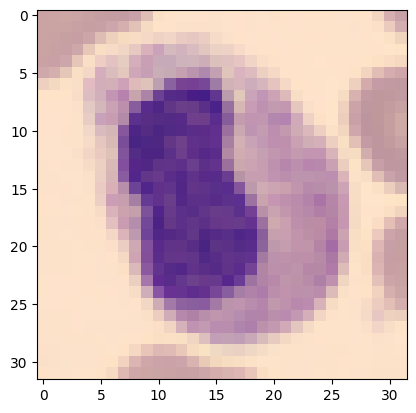

In [168]:
plt.imshow(dataset.imgs[80])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


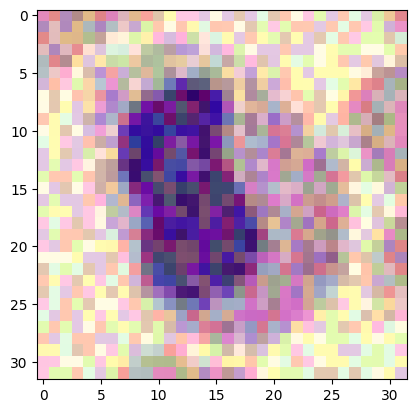

In [169]:
plt.imshow(adversarial_samples[80].detach().numpy().transpose((1, 2, 0)))

In [126]:
len(images_dataset)

13000

In [ ]:











# Query the API with the adversarial inputs
outputs_adv = torch.stack([api_query(input_adv) for input_adv in inputs_adv])

# Retrain the surrogate model with the adversarial examples
inputs = torch.cat((inputs, inputs_adv))
outputs = torch.cat((outputs, outputs_adv))
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(len(inputs)):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = surrogate(inputs[i].unsqueeze(0))
        loss = criterion(output, outputs[i].unsqueeze(0))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(inputs)))

print('Finished Retraining')